In [1]:

import os
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__vsc_ipynb_file__), '../../')))
from gestures import config as cfg
from gestures.data_loader.tiny_data_loader import get_tiny_data_loader


In [34]:

def doppler_map(x: np.ndarray, ax: int = 1) -> np.ndarray:
    """input shape is (N,doppler_points,range_points)"""
    if ax == 1:
        assert x.ndim == 3, f"ax is {ax} so data must be 3D"
    if ax == 0:
        assert x.ndim == 2, f"ax is {ax} so data must be 2D"
    return np.abs(fftshift(fft(x, axis=ax), axes=ax))


def show_res(res:dict, num:int):
    high_res = res['true'][0][num].detach().numpy()
    high_res_l1 = res['pred_l1_loss'][0][num].detach().numpy()
    high_res_ms = res['pred_ms_loss'][0][num].detach().numpy()
    doppler_l1 = doppler_map(high_res_l1[0] + 1j * high_res_l1[1], ax=0)
    doppler_ms = doppler_map(high_res_ms[0] + 1j * high_res_ms[1], ax=0)
    doppler_true = doppler_map(high_res[0] + 1j * high_res[1], ax=0)
    plt.figure(figsize=(20, 20))
    plt.imshow(doppler_true)
    plt.title("True")
    plt.figure(figsize=(20, 20))

    plt.imshow(doppler_l1)
    plt.title("L1")
    plt.figure(figsize=(20, 20))

    plt.imshow(doppler_ms)
    plt.title("MS")
    
    mse_l1 = np.mean(np.square(high_res_l1 - high_res))
    mse_ms = np.mean(np.square(high_res_ms - high_res))
    print(f"L2 loss L1: {mse_l1}")
    print(f"L2 loss MS: {mse_ms}")
    


In [4]:
from gestures.main import get_pc_cgf


pc = cfg.pc
data_dir, output_dir, device = get_pc_cgf(pc)

# getting data loaders
data_cfg = cfg.data_cfg
data_preprocessing_cfg = cfg.data_preprocessing_cfg
trainloader, valloader = get_tiny_data_loader(
    data_dir=data_dir,
    data_scg=data_cfg,
    data_preprocessing_cfg=data_preprocessing_cfg,
    use_pool=False,
    batch_size=cfg.batch_size,
)

loading data with 8 cpu cores


In [5]:


from gestures.network.models.super_resolution.drln import Drln


path_ms = "/Users/netanelblumenfeld/Desktop/bgu/Msc/4090/Radar/outputs/models/sr/Drln_2/lr_0.0018_batch_size_64_loss_MSSSIML1/2024-01-15_17:03:18fffmin_loss_model.pt"
path_l1 = "/Users/netanelblumenfeld/Desktop/bgu/Msc/4090/Radar/outputs/models/sr/Drln_2/ds_4_original_dim_False_pix_norm_Normalization.Range_0_1/lr_0.0015_batch_size_64_loss_L1/2024-01-11_14:43:43min_loss_model.pt"
optimizeer = torch.optim.Adam
drln = Drln
args = {'num_drln_blocks' : 2, 'scale': 4, 'num_channels':  2}
model_ms,a,b,ms = drln.load_model(path_ms, optimizeer, {'lr':0.001},device=device, **args)
model_l1,a,b,l1 = drln.load_model(path_l1, optimizeer, {'lr':0.001},device=device, **args)
model_ms.eval()
model_l1.eval()

print(ms,l1)


0.20212459357838525 0.07520895775377266


In [6]:
results = {"true": [], "pred_ms_loss": [],"pred_l1_loss":[]}
for x,y in valloader:
    high_res = y[0].reshape(30,2,32,492)
    low_res = x.reshape(30,2,8,123)
    res_ms = model_ms(low_res)
    res_l1 = model_l1(low_res)
    results["true"].append(high_res)
    results["pred_ms_loss"].append(res_ms)
    results["pred_l1_loss"].append(res_l1)
    break

L2 loss L1: 0.0034288628958165646
L2 loss MS: 0.0028099596966058016


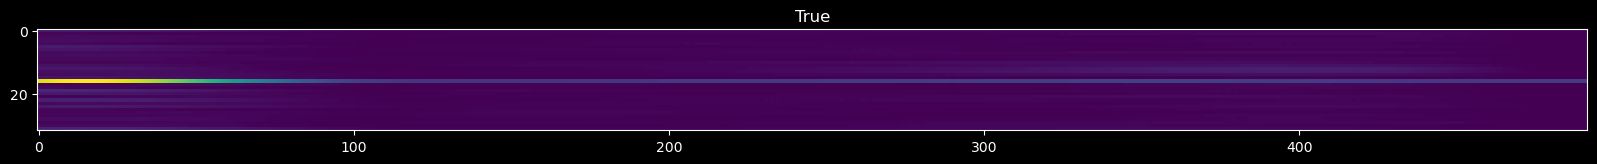

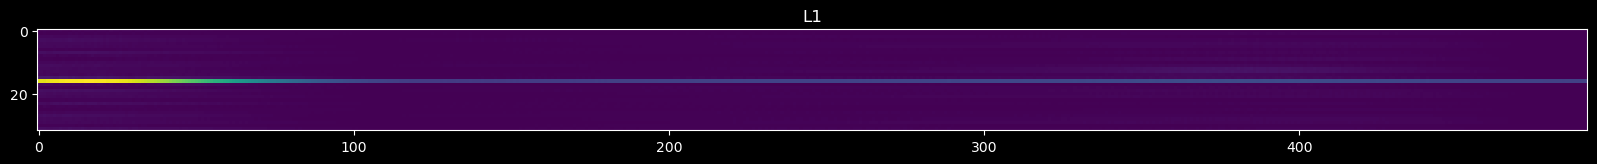

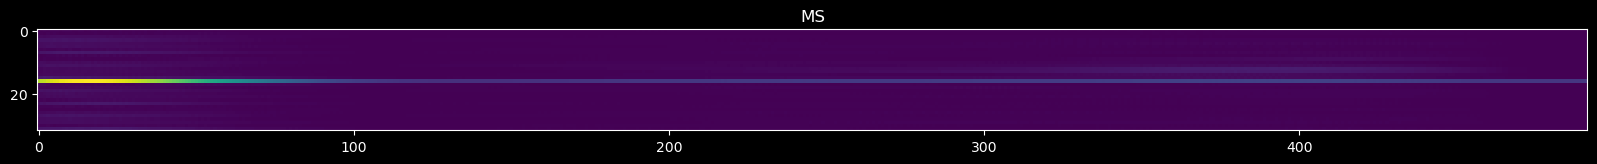

In [35]:
show_res(results, 1)

L2 loss L1: 0.004813637584447861
L2 loss MS: 0.0027421365957707167


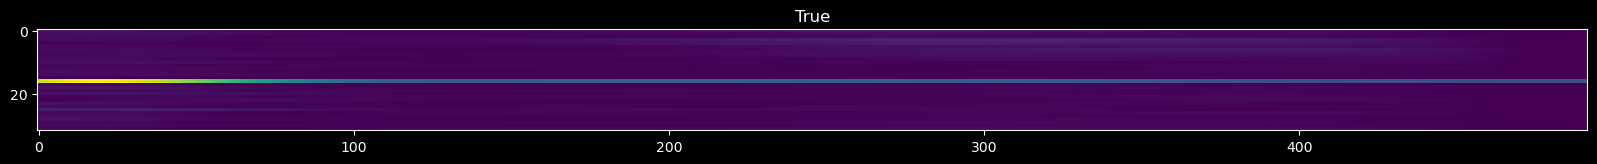

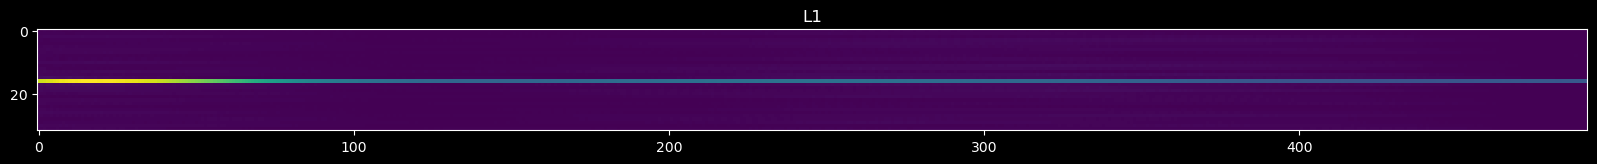

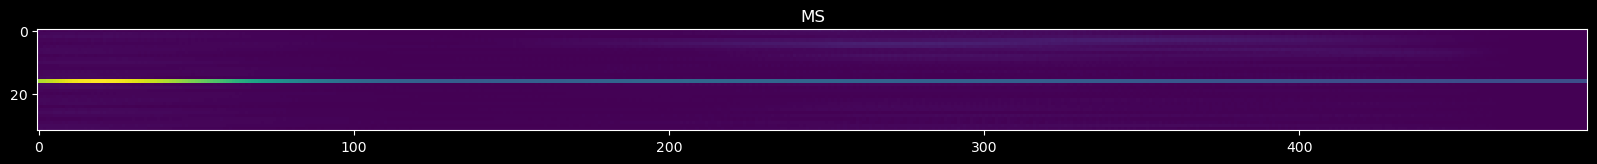

In [36]:
show_res(results, 2)


L2 loss L1: 0.005117872729897499
L2 loss MS: 0.003444078378379345


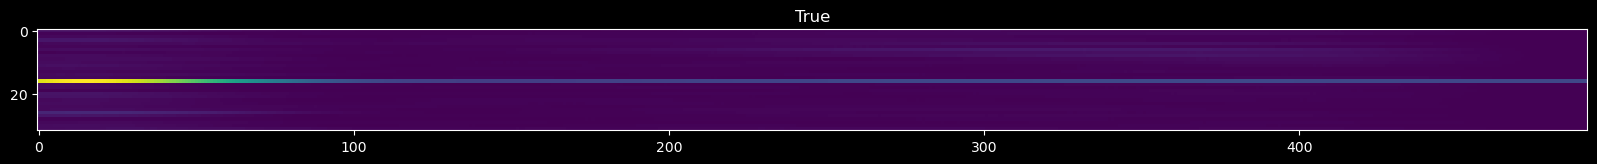

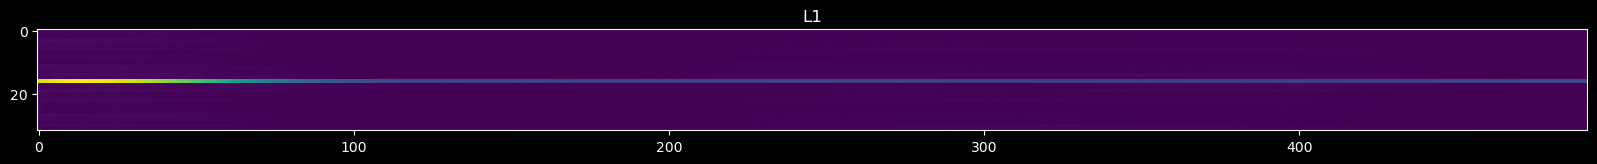

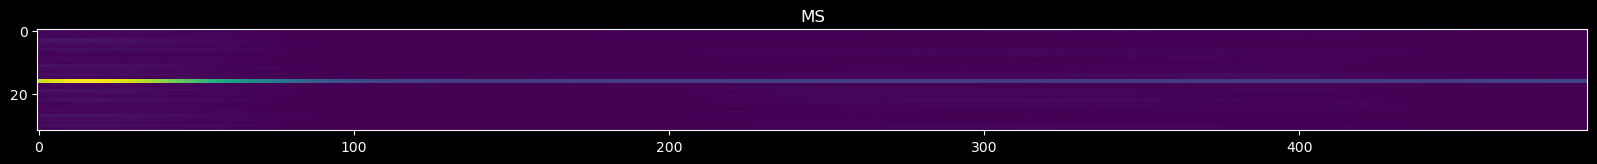

In [37]:
show_res(results, 3)


L2 loss L1: 0.0069056726060807705
L2 loss MS: 0.0038813806604593992


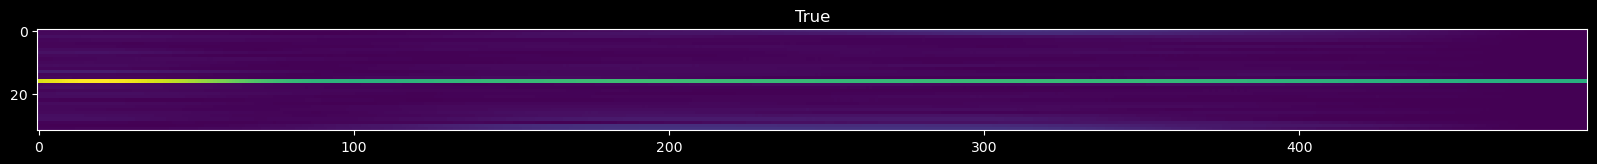

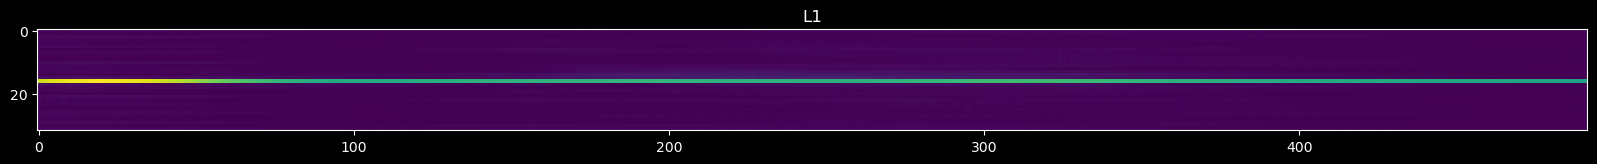

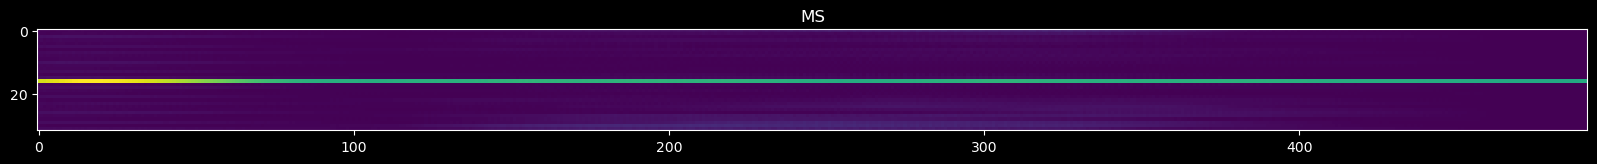

In [38]:
show_res(results, 4)


L2 loss L1: 0.01819937489926815
L2 loss MS: 0.006108167115598917


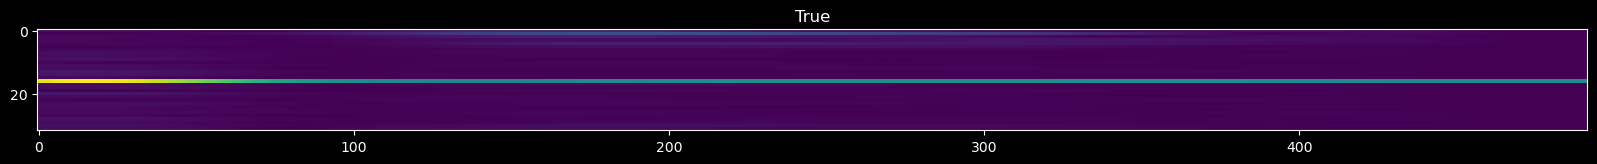

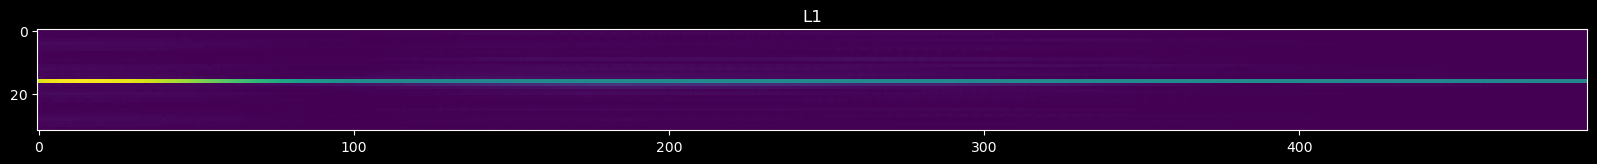

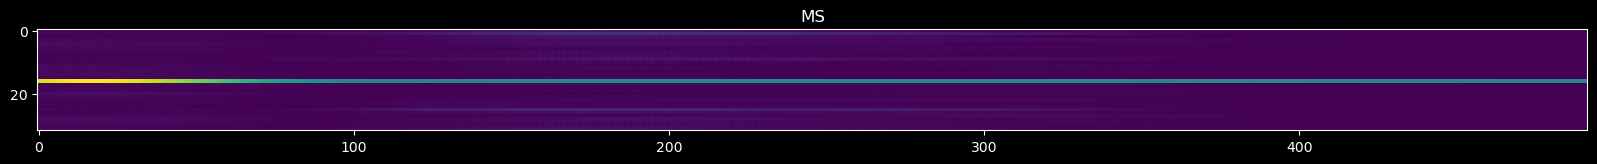

In [39]:
show_res(results, 5)


In [41]:
torch.max(torch.Tensor([2,3]))

tensor(3.)

In [46]:
t = torch.Tensor([2,-torch.inf,3])
opt = torch.min
opt(t)

tensor(-inf)

In [43]:
torch.inf

inf